<a href="https://colab.research.google.com/github/suri199507/image_processing_deep-learning/blob/master/SSD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!ls

adc.json		    output.zip
cropped_img		    pack_detector
GroceryDataset_part1_1	    pack_detector.zip
GroceryDataset_part1_1.zip  sample_data
model_data		    ssd_mobilenet_v1_coco_2017_11_17.tar.gz
models			    tensorflow-1.15.2


In [0]:
download = drive.CreateFile({'id':'1xepetD5kn2PbwE6hSPcFeTyuHtkEKuPI'})
download.GetContentFile('GroceryDataset_part1_1.zip')


In [0]:
download = drive.CreateFile({'id':'1a6C6hqOeuvtQCEyZM3WlVB25VLmSgrc2'})
download.GetContentFile('pack_detector.zip')


In [0]:
!unzip --qq pack_detector.zip

In [0]:
download = drive.CreateFile({'id':'1i6Jj9RUTluqTAxrMcr95C_oYKem4589Z'})
download.GetContentFile('model_data.zip')


In [0]:
!unzip --qq GroceryDataset_part1_1.zip

In [0]:
!unzip --qq model_data.zip 


In [0]:
#!pip install -U  tensorflow=="1.15.0"
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 33.5MB/s 
     |████████████████████████████████| 3.8MB 32.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cca49d1ab89206f413cb3f9903074f1a47c7f11567f9c6451688f80697fdc42c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installatio

In [0]:
!pip install pycocotools

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2606, done.
remote: Counting objects: 100% (2606/2606), done.
remote: Compressing objects: 100% (2289/2289), done.
remote: Total 2606 (delta 508), reused 1320 (delta 282), pack-reused 0
Receiving objects: 100% (2606/2606), 31.40 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (508/508), done.


In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [0]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1082206 sha256=b1789d38e4594898258985777565fe496ec249e854d7f05fdc588abbfe0afd10
  Stored in directory: /tmp/pip-ephem-wheel-cache-o3zadvy_/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
import cv2
import pandas as pd
import numpy as np
import os
import io
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [0]:
!mkdir cropped_img
!mkdir cropped_img/train
!mkdir cropped_img/eval

In [0]:
#training images path
image_path = 'GroceryDataset_part1_1/ShelfImages/ShelfImages/train/'
# cropped parts destination
cropped_path = 'cropped_img/'
# Step 1 results path
data_path = 'data/'
# output destination
detector_data_path = 'pack_detector/data/'

In [0]:
!mkdir pack_detector/data/eval

In [0]:
# read rects and photos dataframes
photos = pd.read_pickle(f'model_data/photos.pkl')
products = pd.read_pickle(f'model_data/products.pkl')

In [0]:
N_CROP_TRIALS = 6
CROP_SIZE = 1000

In [0]:
# returns random value in [s, f]
def rand_between(s, f):
    if s == f:
        return s
    return np.random.randint(s, f)

In [0]:
train_products, eval_products = [], []
for img_file, is_train in photos[['file', 'is_train']].values:
    img = cv2.imread(f'{image_path}{img_file}')
    img_h, img_w, img_c = img.shape
    for n in range(N_CROP_TRIALS):
        # randomly crop square
        c_size = rand_between(300, max(img_h, img_w))
        x0 = rand_between(0, max(0, img_w - c_size))
        y0 = rand_between(0, max(0, img_h - c_size))
        x1 = min(img_w, x0 + c_size)
        y1 = min(img_h, y0 + c_size)
        # products totally inside crop rectangle
        crop_products = products[(products.file == img_file) & 
                                 (products.xmin > x0) & (products.xmax < x1) &
                                 (products.ymin > y0) & (products.ymax < y1)]
        # no products inside crop rectangle? cropping trial failed...
        if len(crop_products) == 0:
            continue
        # name the crop
        crop_img_file = f'{img_file[:-4]}{x0}_{y0}_{x1}_{y1}.JPG'
        # crop and reshape to CROP_SIZExCROP_SIZE or smaller 
        # keeping aspect ratio
        crop = img[y0:y1, x0:x1]
        h, w, c = crop.shape
        ratio = min(CROP_SIZE/h, CROP_SIZE/w)
        crop = cv2.resize(crop, (0,0), fx=ratio, fy=ratio)
        crop = crop[0:CROP_SIZE, 0:CROP_SIZE]
        h, w, c = crop.shape
        # add crop inner products to train_products or eval_products list
        for xmin, ymin, xmax, ymax in \
                crop_products[['xmin', 'ymin', 'xmax', 'ymax']].values:
            xmin -= x0
            xmax -= x0
            ymin -= y0
            ymax -= y0

            xmin, xmax, ymin, ymax = [int(np.round(e * ratio)) 
                                      for e in [xmin, xmax, ymin, ymax]]
            product = {'filename': crop_img_file, 'class':'pack', 
                       'width':w, 'height':h,
                       'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax}
            if is_train:
                train_products.append(product)
            else:
                eval_products.append(product)
        # save crop top eval or train folder
        subpath = ['eval/', 'train/'][is_train]
        cv2.imwrite(f'{cropped_path}{subpath}{crop_img_file}', crop)


In [0]:
train_df = pd.DataFrame(train_products).set_index('filename')
eval_df = pd.DataFrame(eval_products).set_index('filename')

In [0]:
# at this point we have two folders with images and
# two dataframes with information about packs
train_df.head()

,class,width,height,xmin,ymin,xmax,ymax
filename,,,,,,,
C3_P03_N1_S4_1514_320_2063_1869.JPG,pack,1000,1000,283,726,412,943
C3_P03_N1_S4_1514_320_2063_1869.JPG,pack,1000,1000,673,767,804,950
C3_P03_N1_S4_1514_320_2063_1869.JPG,pack,1000,1000,789,770,921,953
C3_P03_N1_S4_1514_320_2063_1869.JPG,pack,1000,1000,541,762,673,945
C3_P03_N1_S4_1514_320_2063_1869.JPG,pack,1000,1000,409,757,541,940


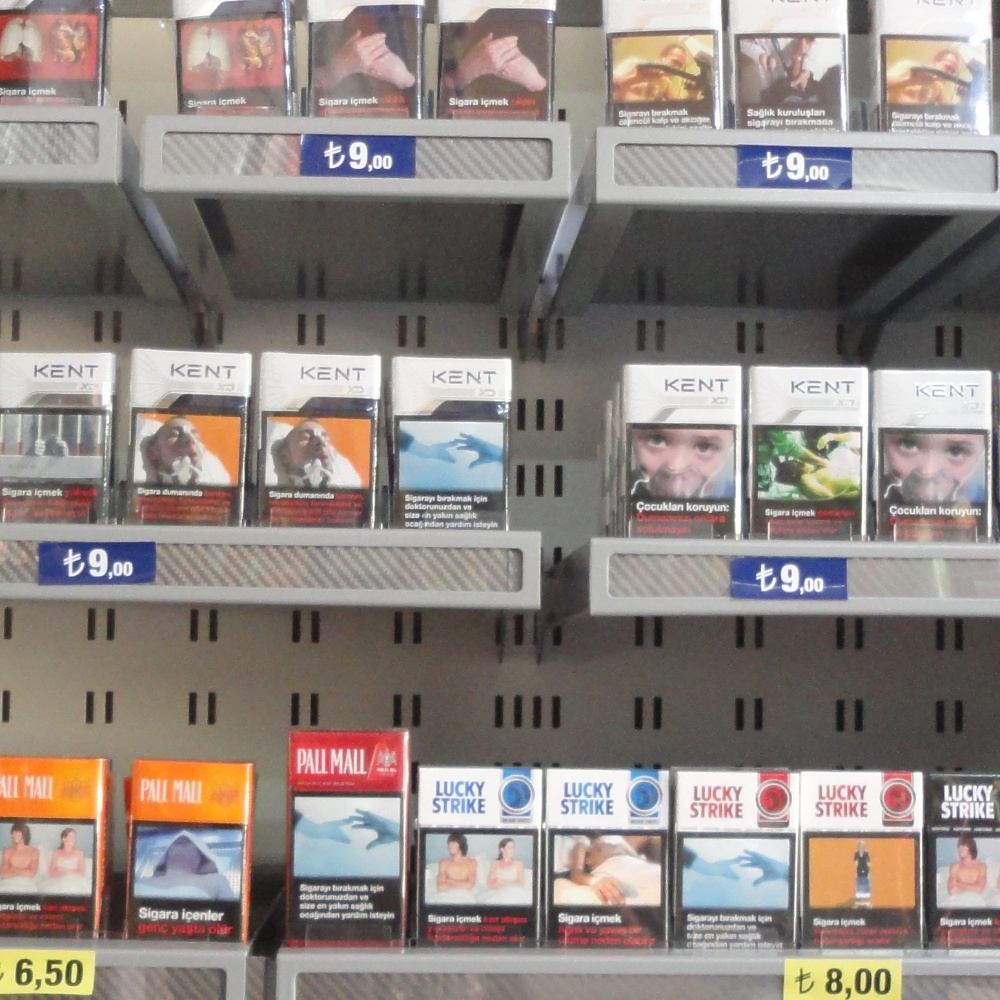

In [0]:
# example of training image
from IPython.display import Image as IPythonImage
IPythonImage(f'{cropped_path}train/{train_df.index.values[0]}', width=600)

In [0]:
def class_text_to_int(row_label):
    if row_label == 'pack':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) 
            for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [0]:
def convert_to_tf_records(images_path, examples, dst_file):
    writer = tf.io.TFRecordWriter(dst_file)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, images_path)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [0]:
convert_to_tf_records(f'{cropped_path}train/', train_df, f'{detector_data_path}train.record')
convert_to_tf_records(f'{cropped_path}eval/', eval_df, f'{detector_data_path}eval.record')

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

--2020-05-18 06:38:54--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.140.128, 2a00:1450:400c:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.140.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76534733 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  72.99M  48.6MB/s    in 1.5s    

2020-05-18 06:38:56 (48.6 MB/s) - ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’ saved [76534733/76534733]

